**Active Learning**

In standard regression machine learning practice, we train an ML model to replace expensive experiments and simulations with a predictive model that gives the same output. However, the ML model must be trained using data generated from the relevant experiments or simulations.

In your problem, a number of experiments should be conducted to obtain the heat flux using the five inputs you showed me. In the standard approach, you will conduct a number of **random experiments** say 200, then you will use this data to train and test your ML model; you will make more experiments and generate more data if your ML model performance is unsatisfactory.

Training your model by random samples is insufficient, especially if your problem is highly nonlinear and many training samples are required. As a result, many expensive and time consuming experiments are required. You may generate 1000 samples by experiments but more than half of them are not useful to your ML model.

Consider that you have 5 inputs, you have thousands of combinations like the ones you showed me; you have 20k different combinations, and possibly more that can be used. The question, **which samples among these are the most useful for training?** When the experiment to obtain the heat flux is expensive and time consuming, you want to obtain well trained ML model using as **minimum samples** as possible. This is done by Active Learning.

Up to now, I am assuming that you do not know the heat flux values, and there are thousands of the five input combinations that you can use to obtain the heat flux via experiments. This is just to show the value of active learning. Having the heat flux values does not change much, but frankly make your argument weaker since you already have done the 20k experiments.

As I mentioned, there are thousands of possible combinations for your five inputs. In active learning, you need a **query strategy** to select samples that are the most useful for your ML training. The most common strategy is selecting the samples with the **most uncertainty**. As a result, you need a probabilstic model that provides a measure of uncertainty. The simplest model is the Gaussian Process Regressor (GPR). The figure below shows the active learning loop, where $\hat{\mu}$ and $\hat{\sigma}$ are the mean and standard deviation, respectively. You can simply replace GPR with your probabilistic model. You divide your data into sampling and testing pools. You iteratively select samples from the sampling pool with the **highest** $\hat{\sigma}$, drop them from the sampling pool, and evaluate your model using the testing pool.  

The performance using active learning should be compared with picking random samples from the sampling pool, and active learning must be better. That means, **better metrics MUST be obtained using fewer number of iterations using active learning when compared with the random sampling**.


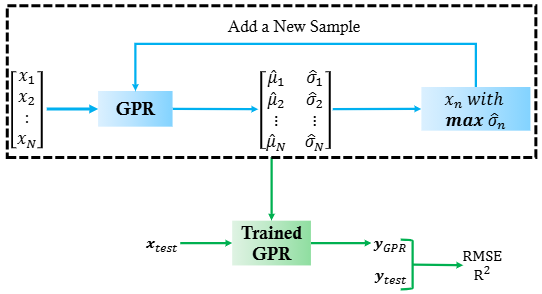



I will show you an example using dataset about ignition delay time of hydrogen. Four inputs are used to predict ignition delay time (tign). The data is linear and easy to learn.   

In [1]:
# You can skip this if you do not use google colab. Put the csv file and modAL folder in your google drive
import os
os.chdir("drive/MyDrive/")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(42)
df = pd.read_csv('dataH2.csv')
df.head()
X = df.drop('tign', axis=1)
y = df['tign']

**modAL** is an active learning package that uses GPR. There are problems with installing it using `pip`. The best way to download the package and use it locally.

In [4]:
# ModAL active learning model
from modAL.models.learners import ActiveLearner
# GPR
from sklearn.gaussian_process import GaussianProcessRegressor
# GPR requires identifying the kernel
from sklearn.gaussian_process.kernels import DotProduct, RBF,  Matern, RationalQuadratic, ExpSineSquared
# R2 and RMSE
from sklearn.metrics import r2_score, mean_squared_error
# Scaling is crucial for GPR
from sklearn.preprocessing import MinMaxScaler
# Sampling/testing split
from sklearn.model_selection import train_test_split

We need to define a query strategy to select the sample with the highest standard deviation.

In [5]:
# Select the prediction y_gp that has the largest standard deviation
# This function returns the index of the
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

Scaling is crucial for GPR to get reasonable resutls

In [6]:
# Split the data into sampling/testing
X_sample, X_test, y_sample, y_test = train_test_split(X, y,
                                                      test_size = 0.2,
                                                      random_state = 42)

# Reshape y from vevtor to matrix for scaling
y_sample = np.array(y_sample).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
# Scaling
# X
y = np.array(y).reshape(-1,1)
scaler_x = MinMaxScaler()
scaler_x.fit(X)
X_sample_scale = scaler_x.transform(X_sample)
X_test_scale = scaler_x.transform(X_test)
# y
scaler_y = MinMaxScaler()
scaler_y.fit(y)
y_sample_scale = scaler_y.transform(y_sample)

Now we need to define the GPR and its kernel

In [7]:
# Defining kernel for Gaussian Process Regressor
kernel = DotProduct() # The best kernel when your data is linear
# Defining GPR
gpr = GaussianProcessRegressor(kernel=kernel,
                        random_state=42,
                        n_restarts_optimizer=0,
                        alpha=1)

You can initialize the GPR with random samples. Note that this step is optional. Also, these random samples are removed from the sampling pool.

In [8]:
# Start with 1 random samples
# Generate 1 random indices
idx_in=np.random.choice(len(X_sample_scale), size=1, replace=False)
# Identify the random samples
X_ini = X_sample_scale[idx_in]
y_ini = y_sample_scale[idx_in]
# Delete these samples from the sampling pool
X_sample = np.delete(X_sample_scale, idx_in, axis=0)
y_sample = np.delete(y_sample_scale, idx_in, axis=0)

# We take copies from the original sampling variables for Random sampling
# The sampling pool will get smaller with iterations
X_sample_in = X_sample.copy()
y_sample_in = y_sample.copy()




Define the active learner

In [9]:
# Use GPR as an Active Learner, Max Std as a query strategy
regressor = ActiveLearner(estimator=gpr,
                             query_strategy=GP_regression_std, # We define this function (GP_regression_std) earlier
                             X_training=X_ini,
                             y_training=y_ini)

Now we need to create the active learning loop using a `for` statement

In [10]:
# Define the number of queries/samples/iterations
n_samples = 200
metrics = []
for i in range (n_samples+1):
        # Identify the sample with the maximum uncertainty
        query_idx, query_instance = regressor.query(X_sample)
        # Fit the model using this sample
        regressor.teach(X_sample[query_idx].reshape(1,-1),
                        y_sample[query_idx].reshape(-1,1))
        # Delete the query from the samples space to avoid reselection
        X_sample = np.delete(X_sample, query_idx, axis=0)
        y_sample = np.delete(y_sample, query_idx, axis=0)
        y_pred = regressor.predict(X_test_scale)
        y_pred = y_pred.reshape(-1,1)
        y_pred_or = scaler_y.inverse_transform(y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_or))
        r2 = r2_score(y_test, y_pred_or)
        metrics.append([i,rmse,r2])
        print(f'Iteration: {i}, RMSE: {rmse}, R2: {r2}')



Iteration: 0, RMSE: 0.015573006869485326, R2: -0.14007116101130346
Iteration: 1, RMSE: 0.00864269642225848, R2: 0.6488557779177078
Iteration: 2, RMSE: 0.00823923870723956, R2: 0.6808747408473569
Iteration: 3, RMSE: 0.008245117760038598, R2: 0.6804191590458553
Iteration: 4, RMSE: 0.00824299533937792, R2: 0.6805836679586011
Iteration: 5, RMSE: 0.008243642466425895, R2: 0.680533513602506
Iteration: 6, RMSE: 0.008257727957618538, R2: 0.6794408687615008
Iteration: 7, RMSE: 0.00825546166028849, R2: 0.6796167967206272
Iteration: 8, RMSE: 0.0059841056659306864, R2: 0.8316607000360335
Iteration: 9, RMSE: 0.005981075933135826, R2: 0.8318311161398697
Iteration: 10, RMSE: 0.006059964570045655, R2: 0.8273656635888161
Iteration: 11, RMSE: 0.006065775731056985, R2: 0.8270344118390571
Iteration: 12, RMSE: 0.005206749025747682, R2: 0.8725557345412298
Iteration: 13, RMSE: 0.0051119547589888676, R2: 0.8771540019820934
Iteration: 14, RMSE: 0.005109379653824705, R2: 0.8772777361314054
Iteration: 15, RMSE: 

Now we want to create a random sampling loop

In [11]:
# Function for Random sample selection
def rand(domain):
    new_idx = np.random.choice(domain, size=1, replace=False)
    return new_idx

# Redefine sampling spaces for random sampling
X_sample_r = X_sample_in.copy()
y_sample_r = y_sample_in.copy()

# Initialize the training using the samples used to initilize AL
X_train = []
y_train = []
for k in range (len(X_ini)):
    X_train.append(X_ini[k])
    y_train.append(y_ini[k])
metrics_rand = []
# Training loop
for j in range (n_samples+1):
    new_idx_r = rand(len(X_sample_r))[0]
    X_train.append(X_sample_r[new_idx_r])
    y_train.append(y_sample_r[new_idx_r])
    gpr.fit(np.array(X_train), np.array(y_train))
    # Delete the query from the samples space to avoid reselection
    X_sample_r = np.delete(X_sample_r, new_idx_r, axis=0)
    y_sample_r = np.delete(y_sample_r, new_idx_r, axis=0)
    # Predict
    y_pred_r = gpr.predict(X_test_scale)
    y_pred_r = y_pred_r.reshape(-1,1)
    y_pred_r_or = scaler_y.inverse_transform(y_pred_r)
    # Metrics
    rmse_r = np.sqrt(mean_squared_error(y_test, y_pred_r_or))
    r2_r = r2_score(y_test, y_pred_r_or)
    metrics_rand.append([j,rmse_r,r2_r])
    print(f'Iteration: {j}, RMSE: {rmse_r}, R2: {r2_r}')

Iteration: 0, RMSE: 0.015553230118784527, R2: -0.1371773606375406
Iteration: 1, RMSE: 0.015544649980545864, R2: -0.13592302985783422
Iteration: 2, RMSE: 0.015251410611367847, R2: -0.0934704144131262
Iteration: 3, RMSE: 0.015342428142596098, R2: -0.10656060695295899
Iteration: 4, RMSE: 0.015341180980090656, R2: -0.10638071302813246
Iteration: 5, RMSE: 0.014993203017066803, R2: -0.05675875108793327
Iteration: 6, RMSE: 0.014993580739733545, R2: -0.05681199745045329
Iteration: 7, RMSE: 0.014998896500783584, R2: -0.05756148564801
Iteration: 8, RMSE: 0.014996612455621972, R2: -0.0572394173844335
Iteration: 9, RMSE: 0.014994674062545408, R2: -0.05696612724927719
Iteration: 10, RMSE: 0.014165657547114636, R2: 0.05667686247134629
Iteration: 11, RMSE: 0.0141783223560311, R2: 0.05498935197553878
Iteration: 12, RMSE: 0.014262925806509612, R2: 0.0436777598437299
Iteration: 13, RMSE: 0.014257047869554005, R2: 0.0444658230543199
Iteration: 14, RMSE: 0.014245030989285867, R2: 0.046075932067108805
Iter

Now let's plot R$^2$ vs the number of iterations for both active learning and random sampling.

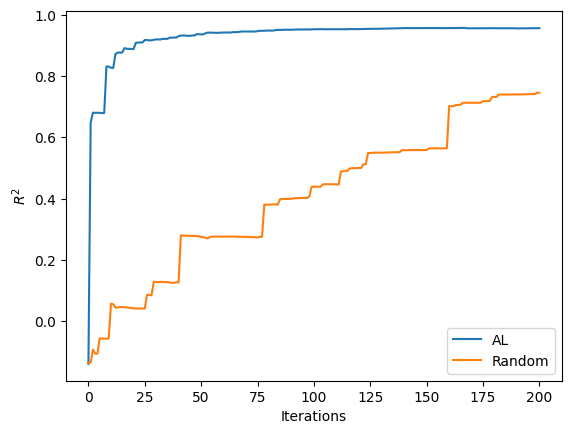

In [12]:
metrics = np.array(metrics)
metrics_rand = np.array(metrics_rand)

plt.plot(metrics[:,0], metrics[:,2])
plt.plot(metrics_rand[:,0], metrics_rand[:,2])
plt.legend(['AL', 'Random'])
plt.xlabel('Iterations')
plt.ylabel('$R^2$')
plt.show()

You can clearly see that Active Learning (AL) sampling is way better than Random sampling. Using 200 samples, we could reach R$^2$ = 0.96 by AL, while R$^2$ = 0.75 using Random sampling, and more samples are needed to get a better  R$^2$, i.e., more expensive simulations.

You can use this notebook for your data, but GPR most likely will fail if the relation between your inputs and output is nonlinear.

